In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Augmentation Functions

In [ ]:
def resampling_fast_random(x):
    M, N = random.choice([[1, 0], [2, 1], [3, 2]])
    time_steps = x.shape[1]
    raw_set = np.arange(x.shape[1])
    interp_steps = np.arange(0, raw_set[-1] + 1e-1, 1 / (M + 1))
    x_interp = interp1d(raw_set, x, axis=1)
    x_up = x_interp(interp_steps)

    length_inserted = x_up.shape[1]
    start = random.randint(0, length_inserted - time_steps * (N + 1))
    index_selected = np.arange(start, start + time_steps * (N + 1), N + 1)
    return x_up[:, index_selected, :]

def resampling(x,M,N):
    '''
    :param x: the data of a batch,shape=(batch_size,timesteps,features)
    :param M: the number of  new value under tow values
    :param N: the interval of resampling
    :return: x after resampling，shape=(batch_size,timesteps,features)
    '''
    assert M>N,'the value of M have to greater than N'

    timesetps = x.shape[1]

    for i in range(timesetps-1):
        x1 = x[:,i*(M+1),:]
        x2 = x[:,i*(M+1)+1,:]
        for j in range(M):
            v = np.add(x1,np.subtract(x2,x1)*(j+1)/(M+1))
            x = np.insert(x,i*(M+1)+j+1,v,axis=1)

    length_inserted = x.shape[1]
    start = random.randint(0,length_inserted-timesetps*(N+1))
    index_selected = np.arange(start,start+timesetps*(N+1),N+1)
    return x[:,index_selected,:]
    return x

def noise(x):
    x = tf.add(x,tf.multiply(x,tf.cast(tf.random.uniform(shape = (x.shape[0],x.shape[1],x.shape[2]),minval=-0.1,maxval=0.1),tf.float64)))
    return x


def scaling(x):
    alpha = np.random.randint(7,10)/10
    # alpha = 0.9
    return tf.multiply(x,alpha)
#
def magnify(x):
    lam = np.random.randint(11,14)/10
    return tf.multiply(x,lam)


def inverting(x):
    return np.multiply(x,-1)
def reversing(x):
    return x[:,-1::-1,:]


def rotation(x):
    c = x.shape[2]//3
    x_new = rotation_transform_vectorized(x[:,:,0:3])
    for i in range(1,c):
        temp = rotation_transform_vectorized(x[:,:,i*3:(i+1)*3])
        x_new = np.concatenate((x_new,temp),axis=-1)
    return x_new
def rotation_transform_vectorized(X):
    """
    Applying a random 3D rotation
    """
    axes = np.random.uniform(low=-1, high=1, size=(X.shape[0], X.shape[2]))
    angles = np.random.uniform(low=-np.pi, high=np.pi, size=(X.shape[0]))
    matrices = axis_angle_to_rotation_matrix_3d_vectorized(axes, angles)

    return np.matmul(X, matrices)
def axis_angle_to_rotation_matrix_3d_vectorized(axes, angles):
    """
    Get the rotational matrix corresponding to a rotation of (angle) radian around the axes
    Reference: the Transforms3d package - transforms3d.axangles.axangle2mat
    Formula: http://en.wikipedia.org/wiki/Rotation_matrix#Axis_and_angle
    """
    axes = axes / np.linalg.norm(axes, ord=2, axis=1, keepdims=True)
    x = axes[:, 0]; y = axes[:, 1]; z = axes[:, 2]
    c = np.cos(angles)
    s = np.sin(angles)
    C = 1 - c

    xs = x*s;   ys = y*s;   zs = z*s
    xC = x*C;   yC = y*C;   zC = z*C
    xyC = x*yC; yzC = y*zC; zxC = z*xC

    m = np.array([
        [ x*xC+c,   xyC-zs,   zxC+ys ],
        [ xyC+zs,   y*yC+c,   yzC-xs ],
        [ zxC-ys,   yzC+xs,   z*zC+c ]])
    matrix_transposed = np.transpose(m, axes=(2,0,1))
    return matrix_transposed
## This example using cubic splice is not the best approach to generate random curves. 
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

  
def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

# Main Cell
## Run this to observe Cumulative and Classwise Results for a particular Augmentation

read h5 file....
(25, 40)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
176/176 [==============================] - 2s 6ms/step - loss: 1.5398 - accuracy: 0.6835 - val_loss: 0.6881 - val_accuracy: 0.7965
Epoch 2/10
176/176 [==============================] - 1s 5ms/step - loss: 0.3519 - accuracy: 0.8868 - val_loss: 0.5167 - val_accuracy: 0.8620
Epoch 3/10
176/176 [==============================] - 1s 5ms/step - loss: 0.1819 - accuracy: 0.9426 - val_loss: 0.4803 - val_accuracy: 0.8748
Epoch 4/10
176/176 [==============================] - 1s 4ms/step - loss: 0.1692 - accuracy: 0.9428 - val_loss: 0.5289 - val_accuracy: 0.8540
Epoch 5/10
176/176 [==============================] - 1s 5ms/step - loss: 0.1213 - accuracy: 0.9609 - val_loss: 0.6500 - val_accuracy: 0.8402
Epoch 6/10
176/176 [==============================] - 1s 5ms/step - loss: 0.1277 - accuracy: 0.9636 - val_loss: 0.5311 - val_accuracy: 0.8716
Epoch 7/10
176/176 [==============================] - 1s 4ms/step - loss: 0.0609 - accuracy: 0.9808 - val_loss: 0.4247 - val_accuracy: 0.9025
Epoch 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


176/176 [==============================] - 2s 6ms/step - loss: 1.4752 - accuracy: 0.6620 - val_loss: 0.6713 - val_accuracy: 0.7874
Epoch 2/10
176/176 [==============================] - 1s 4ms/step - loss: 0.3844 - accuracy: 0.8772 - val_loss: 0.5311 - val_accuracy: 0.8503
Epoch 3/10
176/176 [==============================] - 1s 4ms/step - loss: 0.2359 - accuracy: 0.9273 - val_loss: 0.4405 - val_accuracy: 0.8769
Epoch 4/10
176/176 [==============================] - 1s 5ms/step - loss: 0.1792 - accuracy: 0.9453 - val_loss: 0.4575 - val_accuracy: 0.8753
Epoch 5/10
176/176 [==============================] - 1s 5ms/step - loss: 0.1526 - accuracy: 0.9570 - val_loss: 0.4906 - val_accuracy: 0.8695
Epoch 6/10
176/176 [==============================] - 1s 5ms/step - loss: 0.1823 - accuracy: 0.9479 - val_loss: 0.6339 - val_accuracy: 0.8407
Epoch 7/10
176/176 [==============================] - 1s 5ms/step - loss: 0.1121 - accuracy: 0.9689 - val_loss: 0.4970 - val_accuracy: 0.8833
Epoch 8/10
176/17

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


176/176 [==============================] - 2s 6ms/step - loss: 1.6345 - accuracy: 0.6576 - val_loss: 0.7469 - val_accuracy: 0.7698
Epoch 2/10
176/176 [==============================] - 1s 5ms/step - loss: 0.3799 - accuracy: 0.8792 - val_loss: 0.5694 - val_accuracy: 0.8258
Epoch 3/10
176/176 [==============================] - 1s 5ms/step - loss: 0.2231 - accuracy: 0.9305 - val_loss: 0.4535 - val_accuracy: 0.8689
Epoch 4/10
176/176 [==============================] - 1s 5ms/step - loss: 0.1344 - accuracy: 0.9586 - val_loss: 0.6611 - val_accuracy: 0.8471
Epoch 5/10
176/176 [==============================] - 1s 5ms/step - loss: 0.1452 - accuracy: 0.9542 - val_loss: 0.6417 - val_accuracy: 0.8487
Epoch 6/10
176/176 [==============================] - 1s 5ms/step - loss: 0.1439 - accuracy: 0.9593 - val_loss: 0.4886 - val_accuracy: 0.8865
Epoch 7/10
176/176 [==============================] - 1s 5ms/step - loss: 0.0516 - accuracy: 0.9845 - val_loss: 0.3896 - val_accuracy: 0.9057
Epoch 8/10
176/17

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


176/176 [==============================] - 2s 6ms/step - loss: 1.5108 - accuracy: 0.6741 - val_loss: 0.7298 - val_accuracy: 0.7746
Epoch 2/10
176/176 [==============================] - 1s 7ms/step - loss: 0.3619 - accuracy: 0.8921 - val_loss: 0.5307 - val_accuracy: 0.8370
Epoch 3/10
176/176 [==============================] - 1s 7ms/step - loss: 0.1956 - accuracy: 0.9405 - val_loss: 0.6139 - val_accuracy: 0.8338
Epoch 4/10
176/176 [==============================] - 1s 7ms/step - loss: 0.1417 - accuracy: 0.9602 - val_loss: 0.4568 - val_accuracy: 0.8881
Epoch 5/10
176/176 [==============================] - 1s 5ms/step - loss: 0.1116 - accuracy: 0.9625 - val_loss: 0.5635 - val_accuracy: 0.8679
Epoch 6/10
176/176 [==============================] - 1s 5ms/step - loss: 0.0727 - accuracy: 0.9774 - val_loss: 0.4832 - val_accuracy: 0.8807
Epoch 7/10
176/176 [==============================] - 1s 5ms/step - loss: 0.0327 - accuracy: 0.9890 - val_loss: 0.4721 - val_accuracy: 0.8966
Epoch 8/10
176/17

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


176/176 [==============================] - 2s 6ms/step - loss: 1.3645 - accuracy: 0.6558 - val_loss: 0.6531 - val_accuracy: 0.7826
Epoch 2/10
176/176 [==============================] - 1s 5ms/step - loss: 0.3862 - accuracy: 0.8754 - val_loss: 0.4764 - val_accuracy: 0.8594
Epoch 3/10
176/176 [==============================] - 1s 5ms/step - loss: 0.2160 - accuracy: 0.9344 - val_loss: 0.4911 - val_accuracy: 0.8604
Epoch 4/10
176/176 [==============================] - 1s 4ms/step - loss: 0.1437 - accuracy: 0.9556 - val_loss: 0.5315 - val_accuracy: 0.8705
Epoch 5/10
176/176 [==============================] - 1s 5ms/step - loss: 0.0986 - accuracy: 0.9648 - val_loss: 0.6307 - val_accuracy: 0.8343
Epoch 6/10
176/176 [==============================] - 1s 5ms/step - loss: 0.1137 - accuracy: 0.9659 - val_loss: 0.4379 - val_accuracy: 0.8881
Epoch 7/10
176/176 [==============================] - 1s 5ms/step - loss: 0.0922 - accuracy: 0.9719 - val_loss: 0.5456 - val_accuracy: 0.8780
Epoch 8/10
176/17

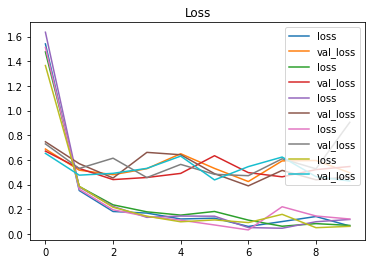

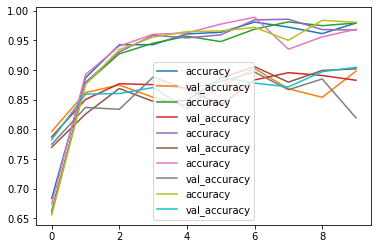

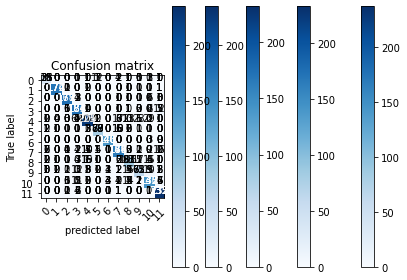

In [ ]:


'''
Apply different deep learning models on PAMAP2 dataset.
ANN,CNN and RNN were applied.

'''
#%%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn import metrics
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, SimpleRNN, GRU, LSTM, GlobalMaxPooling1D,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import random
from scipy.interpolate import interp1d
from keras.utils.vis_utils import plot_model

class models():
    def __init__(self, path):
        self.path = path
    
    def read_h5(self):
        f = h5py.File(path, 'r')
        X = f.get('inputs')
        y = f.get('labels') 
        #print(type(X))
        #print(type(y))
        X = np.array(X)
        y = np.array(y)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.4, random_state = 1)
        x_train=magnify(self.x_train)
        self.x_train=np.concatenate((self.x_train,x_train))
        self.y_train=np.concatenate((self.y_train,self.y_train))
        #print("X = ", X.shape)
        #print("y =",y.shape)
        #print(self.x_train.shape)
        #print(self.x_test.shape)
        #print(self.x_train.shape)
        #return X,y
    
    def cnn_model(self):
       # K = len(set(y_train))
        #print(K)
        K = 12
        #X = np.expand_dims(X, -1)
        self.x_train = np.expand_dims(self.x_train, -1)
        self.x_test = np.expand_dims(self.x_test,-1)
        print(self.x_train.shape)
        print(self.x_test.shape)
        #print(X)
        #print(X[0].shape)
        #i = Input(shape=X[0].shape)
        i = Input(shape=self.x_train[0].shape)
        x = Conv2D(32, (3,3), strides = 2, activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.0005))(i)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(0.2)(x)
        x = Conv2D(64, (3,3), strides = 2, activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.0005))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Conv2D(128, (3,3), strides = 2, activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.0005))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        #x = Dropout(0.2)(x)
        x = Flatten()(x)    
        x = Dropout(0.2)(x)
        x = Dense(1024,activation = 'relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(K, activation = 'softmax')(x)       
        self.model = Model(i,x)
        self.model.compile(optimizer = Adam(lr=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

        #self.r = model.fit(X, y, validation_split = 0.4, epochs = 50, batch_size = 32 )
        self.r = self.model.fit(self.x_train, self.y_train, validation_data = (self.x_test, self.y_test), epochs = 50, batch_size = 32 )
        print(self.model.summary())
        self.model.save_weights('/content/drive/My Drive/Spring22/209AS_Prof_Mani_Course/PAMP dataset/Repo3_JenHuluck/'+str(se))
        self.model.save("'/content/drive/My Drive/Spring22/209AS_Prof_Mani_Course/PAMP dataset/Repo3_JenHuluck/'+str(se)")
        results=self.model.evaluate(self.x_test,self.y_test,batch_size=32)
        print("Test loss, Test Accuracy:", results)
        # It is better than using keras do the splitting!!
        return self.r
    
    def dnn_model(self):
       # K = len(set(y_train))
        #print(K)
        K = 12
        print(self.x_train[0].shape)
        i = Input(shape=self.x_train[0].shape)
        x = Flatten()(i)
        x = Dense(128,activation = 'relu')(x)
        #x = Dense(128,activation = 'relu')(x)
        #x = Dropout(0.2)(x)
        x = Dense(256,activation = 'relu')(x)
        #x = Dropout(0.2)(x)
        x = Dense(128,activation = 'relu')(x)
        x = Dense(K,activation = 'softmax')(x)
        self.model = Model(i,x)      
        self.model.compile(optimizer = Adam(lr=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
        
        '''
        model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=self.x_train[0].shape),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(K,activation = 'softmax')
        ])
        model.compile(optimizer = Adam(lr=0.0005),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
        '''
        self.r = self.model.fit(self.x_train, self.y_train, validation_data = (self.x_test, self.y_test), epochs = 10, batch_size = 32 )
        print(self.model.summary())
        self.model.save_weights('/content/drive/My Drive/Spring22/209AS_Prof_Mani_Course/PAMP dataset/Repo3_JenHuluck/'+str(se))
        self.model.save("'/content/drive/My Drive/Spring22/209AS_Prof_Mani_Course/PAMP dataset/Repo3_JenHuluck/'+str(se)")
        results=self.model.evaluate(self.x_test,self.y_test,batch_size=32)
        print("Test loss, Test Accuracy:", results)
        return self.r
    

    def rnn_model(self):
        K = 12
        i = Input(shape = self.x_train[0].shape)
        x = LSTM(256, return_sequences=True)(i)
        x = Dense(128,activation = 'relu')(x)
        x = GlobalMaxPooling1D()(x)
        x = Dense(K,activation = 'softmax')(x)
        self.model = Model(i,x)      
        self.model.compile(optimizer = Adam(lr=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
        self.r = self.model.fit(self.x_train, self.y_train, validation_data = (self.x_test, self.y_test), epochs = 50, batch_size = 32 )
        #self.r = model.fit(X, y, validation_split = 0.2, epochs = 10, batch_size = 32 )
        print(self.model.summary())
        self.model.save_weights('/content/drive/My Drive/Spring22/209AS_Prof_Mani_Course/PAMP dataset/Repo3_JenHuluck/'+'RNN'+str(se))
        self.model.save('/content/drive/My Drive/Spring22/209AS_Prof_Mani_Course/PAMP dataset/Repo3_JenHuluck/'+'RNN'+str(se))
        results=self.model.evaluate(self.x_test,self.y_test,batch_size=32)
        print("Test loss, Test Accuracy:", results)
        return self.r
   
    def draw(self):
        f1 = plt.figure(1)
        plt.title('Loss')
        plt.plot(self.r.history['loss'], label = 'loss')
        plt.plot(self.r.history['val_loss'], label = 'val_loss')
        plt.legend()
        f1.show()
        
        f2 = plt.figure(2)
        plt.plot(self.r.history['accuracy'], label = 'accuracy')
        plt.plot(self.r.history['val_accuracy'], label = 'val_accuracy')
        plt.legend()
        f2.show()
        
    # summary, confusion matrix and heatmap
    def con_matrix(self):
        K = len(set(self.y_train))
        self.y_pred = self.model.predict(self.x_test).argmax(axis=1)
        cm = confusion_matrix(self.y_test,self.y_pred)
        self.plot_confusion_matrix(cm,list(range(K)))
        print("Class-wise Accuracy")
        print(cm.diagonal()/cm.sum(axis=1))
        

    def plot_confusion_matrix(self, cm, classes, normalize = False, title='Confusion matrix', cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
            print("Normalized confusion matrix")
        else:
            print("Confusion matrix, without normalization")
        print(cm)
        f3 = plt.figure(3)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        
        fmt = '.2f' if normalize else 'd' 
        thresh = cm.max()/2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('predicted label')
            f3.show()
                


if True:
    model_name = "cnn" # can be cnn/dnn/rnn
    path = "/content/drive/My Drive/Spring22/209AS_Prof_Mani_Course/PAMP dataset/Repo3_JenHuluck/pamap_scaled2.h5"
    #path = '/content/pamap_scaled2.h5'
    pamap = models(path)
    print("read h5 file....")
    pamap.read_h5()
    seed_list=[1234,42,500,2000,100]
    if model_name == "cnn":
      for se in seed_list:
        tf.random.set_seed(se)
        pamap.cnn_model()
        pamap.draw()
        pamap.con_matrix()
  #model.summary()
  #X_train_Aug= resampling(X_train,1,0) 
        
    elif model_name == "dnn":
      for se in seed_list:
        tf.random.set_seed(se)
        pamap.dnn_model()
        pamap.draw()
        pamap.con_matrix()
    elif model_name == "rnn":
      for se in seed_list:
        tf.random.set_seed(se)
        pamap.rnn_model()
        pamap.draw()
        pamap.con_matrix()
    # pamap.draw()
    # pamap.con_matrix()
    '''
    x_train,y_train,x_test,y_test = pamap.read_h5()
    print("use slicing windows to segment....")
    x_train, y_train = pamap.segment(x_train,y_train,input_width)
    x_test, y_test = pamap.segment(x_test,y_test,input_width)
    print("x_train shape = ", x_train.shape)
    print("y_train shape =",y_train.shape)
    print("x_test shape =" ,x_test.shape)
    print("y_test shape =",y_test.shape)
    print("train and test data were processed.")
    if model_name == "cnn":
        pamap.cnn_model(x_train, y_train, x_test, y_test)
    elif model_name == "dnn":
        pamap.dnn_model(x_train, y_train, x_test, y_test)
    elif model_name == "rnn":
        pamap.rnn_model(x_train, y_train, x_test, y_test)
    pamap.draw()
    '''

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.preprocessing import MinMaxScaler, StandardScaler

activityIDdict = {0: 'transient',
              1: 'lying',# no change in index
              2: 'sitting',# no change in index
              3: 'standing',# no change in index
              4: 'walking',# no change in index
              5: 'running',# no change in index
              6: 'cycling',# no change in index
              7: 'Nordic_walking',# no change in index
              9: 'watching_TV', # not in dataset
              10: 'computer_work',# not in dataset
              11: 'car driving', # not in dataset
              12: 'ascending_stairs', # new index:8
              13: 'descending_stairs', # new index:9
              16: 'vacuum_cleaning', # new index:10
              17: 'ironing', # new index:11
              18: 'folding_laundry',# not in dataset
              19: 'house_cleaning', # not in dataset
              20: 'playing_soccer', # not in dataset
              24: 'rope_jumping' # new index: 0 
              }
#{24:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,12:8,13:9,16:10,17:11}
              
def read_files():
    list_of_files = ['./Protocol/subject101.dat',
                     './Protocol/subject102.dat',
                     './Protocol/subject103.dat',
                     './Protocol/subject104.dat',
                     './Protocol/subject105.dat',
                     './Protocol/subject106.dat',
                     './Protocol/subject107.dat',
                     './Protocol/subject108.dat',
                     './Protocol/subject109.dat' ]
    
    subjectID = [1,2,3,4,5,6,7,8,9]
    

    
    colNames = ["timestamp", "activityID","heartrate"]
    
    IMUhand = ['handTemperature', 
               'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
               'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
               'handGyro1', 'handGyro2', 'handGyro3', 
               'handMagne1', 'handMagne2', 'handMagne3',
               'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']
    
    IMUchest = ['chestTemperature', 
               'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
               'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
               'chestGyro1', 'chestGyro2', 'chestGyro3', 
               'chestMagne1', 'chestMagne2', 'chestMagne3',
               'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']
    
    
    IMUankle = ['ankleTemperature', 
               'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
               'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
               'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
               'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
               'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']
    
    columns = colNames + IMUhand + IMUchest + IMUankle
    
    dataCollection = pd.DataFrame()
    for file in list_of_files:
        print(file," is reading...")
        procData = pd.read_table(file, header=None, sep='\s+')
        procData.columns = columns
        procData['subject_id'] = int(file[-5])
        dataCollection = dataCollection.append(procData, ignore_index=True)
        
        #break; # for testing short version, need to delete later
        
    dataCollection.reset_index(drop=True, inplace=True)
    
    return dataCollection

def scale(df):#pandas dataframe   
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    df.iloc[:,[1,-1]] = scaler.fit_transform(df.iloc[:,[1,-1]] )#scale the data of column index [1:-1)
    return df


def dataCleaning(dataCollection):
    dataCollection = dataCollection.drop(['timestamp', 'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                                         'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                                         'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
                                         axis = 1)  # removal of orientation columns as they are not needed
    dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == 0].index) #removal of any row of activity 0 as it is transient activity which it is not used
    dataCollection = dataCollection.apply(pd.to_numeric, errors = 'coerce') #removal of non numeric data in cells
    dataCollection = dataCollection.dropna()
    dataCollection = scale(dataCollection)
    #dataCollection = dataCollection.interpolate() 
    #removal of any remaining NaN value cells by constructing new data points in known set of data points
    #for i in range(0,4):
    #    dataCollection["heartrate"].iloc[i]=100 # only 4 cells are Nan value, change them manually
    print("data cleaned!")
    return dataCollection

def reset_label(dataCollection): 
    # Convert original labels {1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24} to new labels. 
    mapping = {24:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,12:8,13:9,16:10,17:11} # old activity Id to new activity Id 
    for i in [24,12,13,16,17]:
        dataCollection.loc[dataCollection.activityID == i, 'activityID'] = mapping[i]

    return dataCollection

def segment(data, window_size): # data is numpy array
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0
    while start + window_size - 1 < n:
        end = start + window_size-1
        if data[start][0] == data[end][0] and data[start][-1] == data[end][-1] : # if the frame contains the same activity and from the same object
            X.append(data[start:(end+1),1:-1])
            y.append(data[start][0])
            start += window_size//2 # 50% overlap
        else: # if the frame contains different activities or from different objects, find the next start point
            while start + window_size-1 < n:
                if data[start][0] != data[start+1][0]:
                    break
                start += 1
            start += 1
    print(np.asarray(X).shape, np.asarray(y).shape)
    return {'inputs' : np.asarray(X), 'labels': np.asarray(y,dtype=int)}

def downsize(data):# data is numpy array
    downsample_size = 3
    data = data[::downsample_size,:]
    return data

def save_data(data,file_name): # save the data in h5 format
    f = h5py.File(file_name,'w')
    for key in data:
        print(key)
        f.create_dataset(key,data = data[key])       
    f.close()
    print('Done.')    


def plot_series(df, colname, act, subject, start, end):
    unit='ms^-2'
    #pylim =(-25,25)
    #print(df.head())
    df1 = df[(df.activityID ==act) & (df.subject_id == subject)]
    if df1.shape[0] < 1:
        print("Didn't find the region. Please reset activityID and subject_id")
        return
    df_len = df1.shape[0]
    if df_len > start and df_len  > end:
        df1 = df1[start:end]
    elif df_len  > start and df_len  <= end:
        df1 = df1[start:df_len]
    else:
        print("Out of boundary, please reset the start and end points")
    print(df1.shape)
    #print(df1.head(10))
    plottitle = colname +' - ' + str(act)
    #plotx = colname
    fig = df1[colname].plot()
    #print(df.index)
    #ax1 = df1.plot(x=df.index,y=plotx, color='r', figsize=(12,5), ylim=pylim)
    fig.set_title(plottitle)
    fig.set_xlabel('window')
    fig.set_ylabel(unit)
    #fig.show()
    
#visualize the curve in a given window
#with same subject and same activity
#feat:[]
#def visualize(act_id,)
    


if __name__ == "__main__":
    file_name = 'pamap_scaled2.h5'
    window_size = 25
    data = read_files()
    data = dataCleaning(data)
    #plot_series(data,'handAcc16_1',1,1,400,500)
    #plot_series(data,'chestAcc16_1',1,1,400,500)
    #plot_series(data,'ankleAcc16_1',1,1,400,500)
    data = reset_label(data)   
    numpy_data = data.to_numpy()
    numpy_data = downsize(numpy_data) # downsize to 30%
    
    segment_data = segment(numpy_data, window_size)   
    save_data(segment_data, file_name)

In [ ]:
if True: 
    x_train,y_train,x_test,y_test = pamap.read_h5()
    print("use slicing windows to segment....")
    x_train, y_train = pamap.segment(x_train,y_train,input_width)
    x_test, y_test = pamap.segment(x_test,y_test,input_width)
    print("x_train shape = ", x_train.shape)
    print("y_train shape =",y_train.shape)
    print("x_test shape =" ,x_test.shape)
    print("y_test shape =",y_test.shape)
    print("train and test data were processed.")

In [ ]:

cr = classification_report(Y_test, prediction)
print(classification_report(Y_test, prediction))
cm = confusion_matrix(Y_test, prediction)
plot_confusion_matrix(cm)
print("Class-wise Accuracy")
print(cm.diagonal()/cm.sum(axis=1))